# Credit Card Fraud Detection using Isolation Forest and SVM

We have already PCA featured dataset. It is completely imbalanced dataset ( 90% Normal and 10% Fraud output ).
However, we are going to handle it using Local Outlier Factor ( LOF ) algorithm and finally applying Isolation Forest Algorithm.

Isolation Forest Algorithm is same as random forest which uses decision trees. But here we give anomaly score to the leaf nodes as per its depth.

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from pylab import rcParams
#rcParams['figure.figsize'] = 14,8
RANDOM_SEED = 42

In [ ]:
#Importing dataset
dataset = pd.read_csv('creditcard.csv')
dataset.head()

## Exploratory Data Analysis 

In [ ]:
dataset.info()

In [ ]:
dataset.describe()

In [ ]:
dataset.isnull().sum().any() #no null values verified

In [ ]:
#Check the class count ( dependent feature ) for imbalanced condition
print("Total Count : "+str(len((dataset['Class']))))

count_classes = pd.value_counts(dataset['Class'],sort=True)

print("Normal Transaction : "+str(count_classes[0]))
print("Fraud Transaction : "+str(count_classes[1]))

As you can see, this is completely imbalanced dataset.

In [ ]:
#Lets visualize it using count plot
plt.figure(figsize=(8,5))
count_classes.plot(kind="bar",rot=0)

#customize count plot
XLABELS = ["Normal","Fraud"]
plt.title("Transaction Class Distribution")
plt.xticks(range(2),XLABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [ ]:
sns.set_style('whitegrid')
sns.boxplot(x=dataset['Amount'])

In [ ]:
#Get Fraud and Normal Class
Fraud = dataset[dataset["Class"]==1]
Normal = dataset[dataset["Class"]==0]

In [ ]:
Fraud

In [ ]:
Normal

In [ ]:
print(Fraud.shape,Normal.shape)

In [ ]:
#Lets explore the feature : Amount, how do it effect the class?
Fraud.Amount.describe()

In [ ]:
Normal.Amount.describe()

In [ ]:
#Lets see amount transaction per class
f, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(10,10))
f.suptitle('Amount per transaction by class')

bins=20
ax1.hist(Fraud.Amount,bins=bins)
ax1.set_title('Fraud')

ax2.hist(Normal.Amount,bins=bins)
ax2.set_title('Normal')

plt.xlabel('Amount in $')
plt.ylabel('No of Transactions')
plt.xlim((0,20000))
plt.yscale('log')
plt.show()

In [ ]:
#How often do Fraud transaction take place? Or what time does it occur more?

f,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(10,10))
f.suptitle("Time of Transcation vs Amount by class")

ax1.scatter(x=Fraud.Time/3600,y=Fraud.Amount)
ax1.set_title("Fraud Distrubution")

ax2.scatter(x=Normal.Time/3600,y=Normal.Amount)
ax2.set_title("Normal Distribution")

plt.xlabel("Time in Hours")
plt.ylabel("Amount")
plt.show()

In [ ]:
#Since the records are 284807 rows, we will take 1% of it for our purpose of shorter computation time
data = dataset.sample(frac=0.1,random_state=1)
data.shape

In [ ]:
dataset.shape

In [ ]:
#Determine the number of fraud and valid tranasction
Fraud = data[data['Class']==1]
Valid = data[data['Class']==0]

outlier_fraction = float(len(Fraud))/float(len(Valid))

In [ ]:
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(Valid)))
print("Outlier Fraction : "+str(outlier_fraction))

In [ ]:
#Correlation
corr_mat = data.corr()
corr_mat

In [ ]:
top_corr_features = corr_mat.index
top_corr_features

In [ ]:
plt.figure(figsize=(20,20))
g = sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Check the Class vs independent features for correlation : V14 has highest negative correaltion.

In [ ]:
#Splitting the independent features and dependent features
columns = data.columns.tolist()
columns

In [ ]:
#Filter the column with CLASS alone
columns = [c for c in columns if c not in ["Class"]]
columns

In [ ]:
#Define X, Y with random_state
state = np.random.RandomState(42)
X = data[columns]
y = data["Class"]
X_outliers =state.uniform(low=0,high=1,size=(X.shape[0],X.shape[1]))

In [ ]:
X

In [ ]:
y

In [ ]:
X_outliers

In [ ]:
print(X.shape,y.shape)

## Model Prediction 

We do the model prediction via 3 methods :
1. Isolation Forest Algorithm
2. Local Outlier Factor (LOF) Algorithm
3. Support Vector Machine

At last, we will compare the accuracy results of each models.

In [ ]:
##Define the outlier detection methods

import scipy
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

classifiers = {
    
    "Isolation Forest" : IsolationForest(n_estimators=100,
                                        max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state,
                                        verbose=0),
    
    "Local Outlier Factor" : LocalOutlierFactor(n_neighbors=20,
                                               algorithm='auto',
                                               leaf_size=30,
                                               metric='minkowski',
                                               p=2,
                                               metric_params=None,
                                               contamination=outlier_fraction),
    
    "Support Vector Machine" : OneClassSVM(kernel='rbf',
                                          degree=3,
                                          gamma=0.1,
                                          nu=0.05,
                                          max_iter=-1,
                                          random_state=state)
    
}

In [ ]:
type(classifiers)

In [ ]:
classifiers

In [ ]:
n_outliers = len(Fraud)
n_outliers

In [ ]:
for i , (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
        
    else:
        clf.fit(X)
        scores_prediction =clf.decision_function(X)
        y_pred = clf.predict(X)

In [ ]:
#Reshape the prediction values to 0 for Valid transaction, 1 for Fraud transaction
y_pred[y_pred == 1] ==0
y_pred[y_pred == -1] ==1
n_errors = (y_pred != y).sum()

In [ ]:
#Run Classification Metrics
print(" {} : {}".format(clf_name,n_errors))
print("Accuracy Scores : ")
print(accuracy_scores(y,y_pred))
print("Classification Scores : ")
print(classfication_report(y,y_pred))

In [2]:
result = pd.DataFrame({
    "Model" : ["Support Vector Machine","Local Outlier Factor","Isolation Forest"],
    "Accuracy (%)" : [77,84,96]}
)

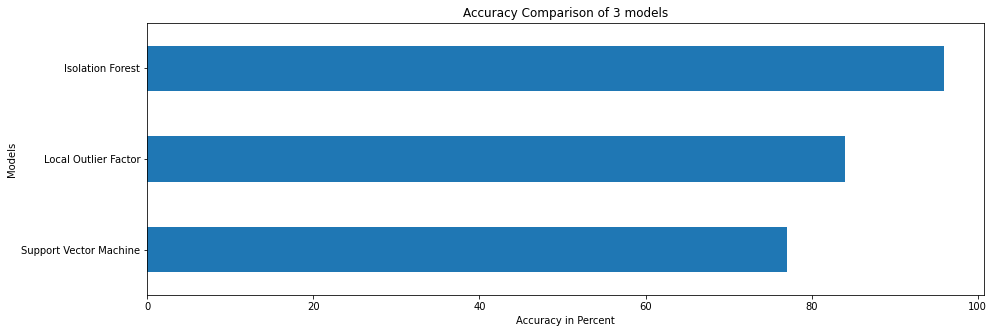

In [3]:
#Lets visualize it using count plot
result.plot(kind="barh",figsize=(15,5),legend=False)

#customize count plot
plt.title("Accuracy Comparison of 3 models")
YLABELS = ["Support Vector Machine","Local Outlier Factor","Isolation Forest"]
plt.yticks(range(3),YLABELS)
plt.ylabel("Models")
plt.xlabel("Accuracy in Percent")
plt.show()